# Main

this notebook is the main file of the project, here the model are trained and evaluated

# Import libraies

In [1]:
#coustom modules
from train import Trainer
from models import Generator, Critic
import data.data_preprocessing as data_prep
import utils
from rescale_generated import Rescale

#pytorch modules
import torch
from torch.utils.data import DataLoader

#general modules
import matplotlib.pyplot as plt
import numpy as np

c:\Users\bolla\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create the dataset

The following function transform the data bere using them as input for the model.

In [2]:
#create the transformer to scale the series
class ScaleInput:
    
    '''
    this transformer scale the sample multiplying each entry by a scaling factor
    ::param:scale: scaling factor
    '''

    def __init__(self, scale:int) -> None:
        self.scale = scale

    def __call__(self, sample:torch.tensor) -> torch.tensor:
        return sample * self.scale

class Magnitude_Scaler:
    '''
    this function scale the given serie in a fixed range
    ::param:scale: a list of two element that are le lower/upper bound of the range
    '''
    def __init__(self, scale:list) -> None:
        self.scale = scale

    def __call__(self, sample:torch.tensor) -> torch.tensor:

        cap = torch.max(sample)
        bottom = torch.min(sample)

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (self.scale[1] - self.scale[0]) + self.scale[0]
        
        return X_scaled

class LogReturns:

    '''
    this function turns a serie of price into log returns. To use this function you need to pass a price dataset
    '''
    
    def __call__(self, sample:torch.tensor) -> torch.tensor:

        R_t = sample[1:]/sample[:-1]
        R_t.apply_(lambda x: np.log(x))

        return R_t

the following code create the dataset and plot some sample of the dataset series

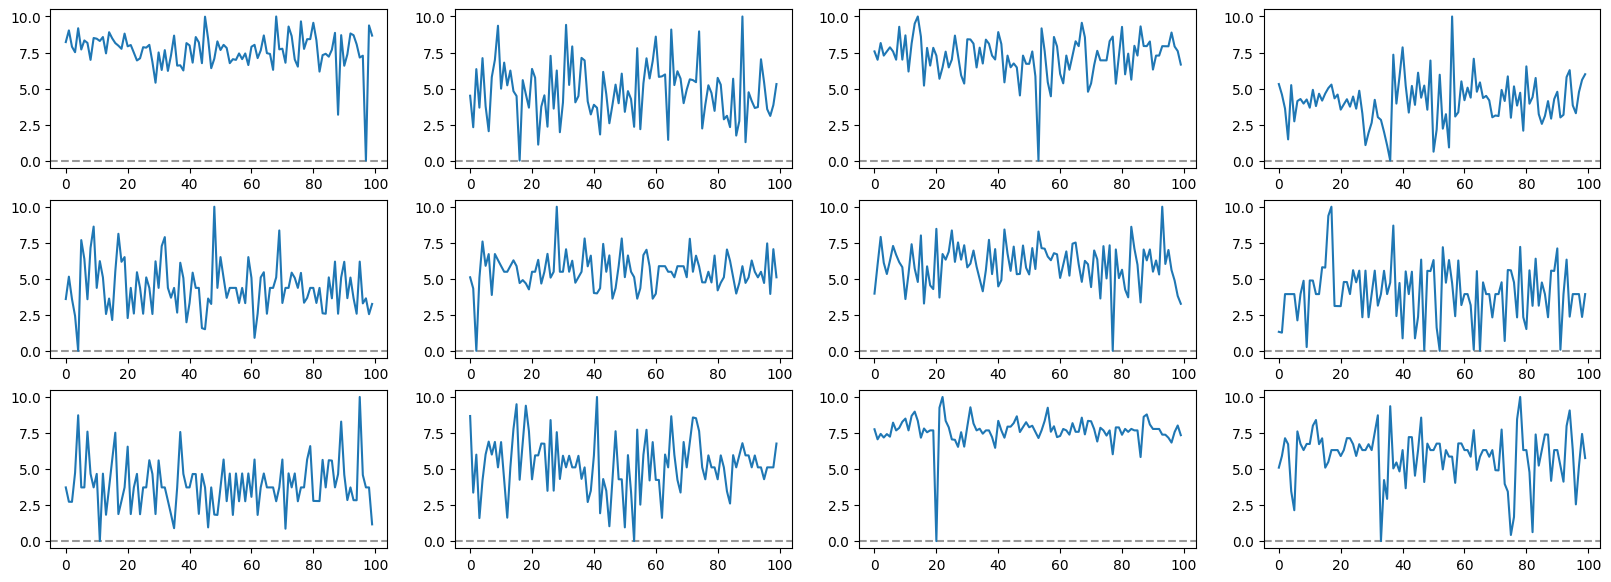

In [3]:
#initialize the transformer
scaler_p = ScaleInput([100])
get_log_returns = LogReturns()
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds',transform = scaler_p)

#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(20,7))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

# Model initialization and training

the following box of code contains all the hyperparameters for the model training

In [43]:
#chose the Base directiory to save the run
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
G_NORM_PEN = 5
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = utils.create_dir(BASE_DIR,'price_001')

<h3>Select a model to use/train</h3>

In [4]:
# Instantiate Generator and Critic + initialize weights
from checkpoints import models as models_test
state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))

g = models_test.Generator()
g.load_state_dict(state_dicts['g_state_dict'])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
#adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
#grater for discriminator the lr


c = models_test.Critic()
c.load_state_dict(state_dicts['d_state_dict'])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)


<h3>Initialize new models</h3>

In [44]:
g = Generator()
#g_opt = torch.optim.Adam(g.parameters(), lr=0.003, betas=[0.5, 0.99])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

c = Critic()
#c_opt = torch.optim.Adam(c.parameters(), lr=0.009, betas=[0.5, 0.99])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

<h2>Model Training</h2>

In [45]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,G_NORM_PEN,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

Training is about to start...


100%|██████████| 40/40 [48:44<00:00, 73.11s/it]  


# Evaluate the model

the following code rescale use the model to generate samples of returns and plot the results

<h3>Rescaler</h3>
the following code initialize the rescaler computing its paramethers on the dataset chosen and plot some exemple of its results

In [5]:
#create a non-transformed dataset to initialize the rescaler
plain_dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')
#initialize the rescaler
rescaler = Rescale(plain_dataset, picks_range=0.06)

~Scaler initialization~
~computing the min and max quantiles~


100%|██████████| 10353/10353 [03:03<00:00, 56.36it/s]


~computing the distance between peaks~


100%|██████████| 10353/10353 [01:00<00:00, 170.97it/s]


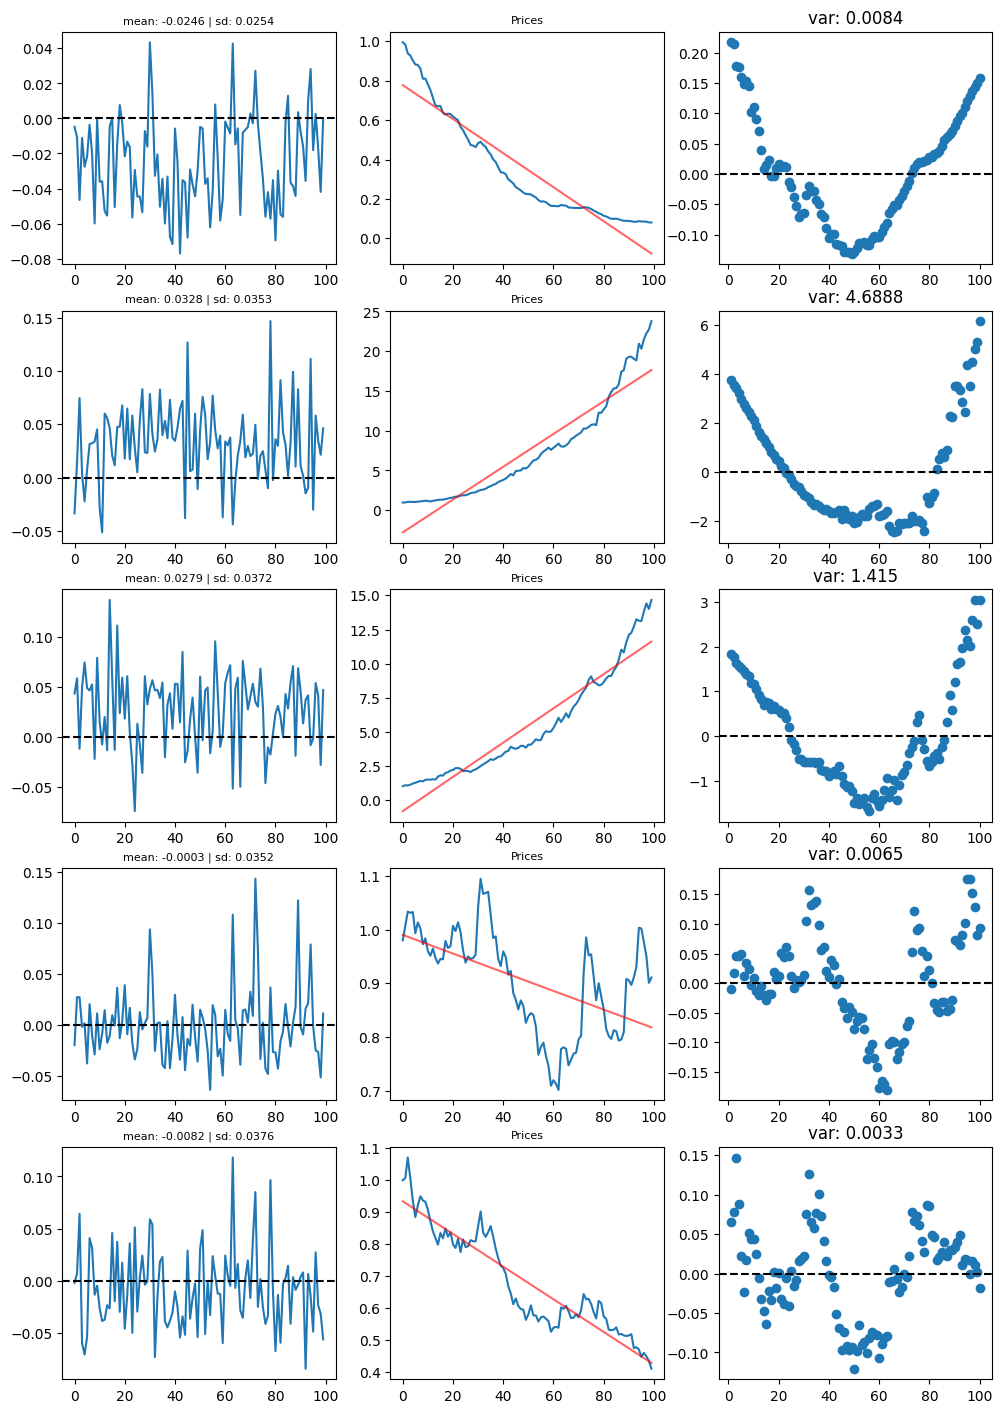

In [22]:
sample = utils.generate_sample(g,5)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))

utils.plot_samples_price(scaled, return_series=False)

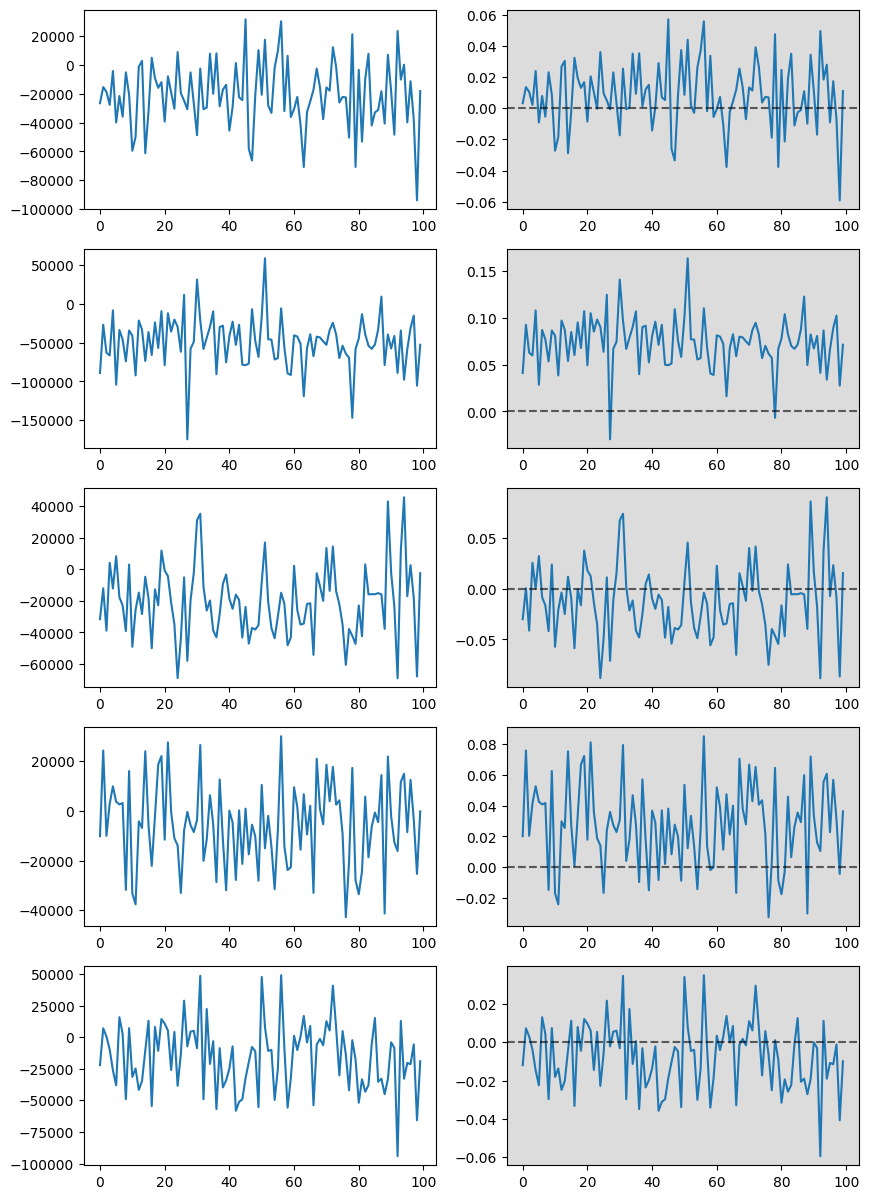

In [62]:
sample = utils.generate_sample(g,5)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))



fig, axs = plt.subplots(len(sample),2)
fig.set_figheight(3*len(sample))
fig.set_figwidth(10)

for i,ax in enumerate(axs):
    sample[i] = sample[i].detach().numpy()
    ax[0].plot(sample[i][0])
    ax[1].plot(scaled[i])
    ax[1].axhline(0, color='black', ls='--', alpha = 0.6)
    ax[1].set_facecolor('gainsboro')

<h2>Create the syntetic dataset</h2>
the following code generate some fake series and plot them

In [24]:
import generate_syntetic_df
from generate_syntetic_df import DfGenerator

In [42]:
import importlib
import generate_syntetic_df
importlib.reload(generate_syntetic_df)
from generate_syntetic_df import DfGenerator

In [44]:
df_generator = DfGenerator(variance_th=[6,8], max_range=0.15,generator=g, rescaler=rescaler)
syntetic_df, it = df_generator(size=10)

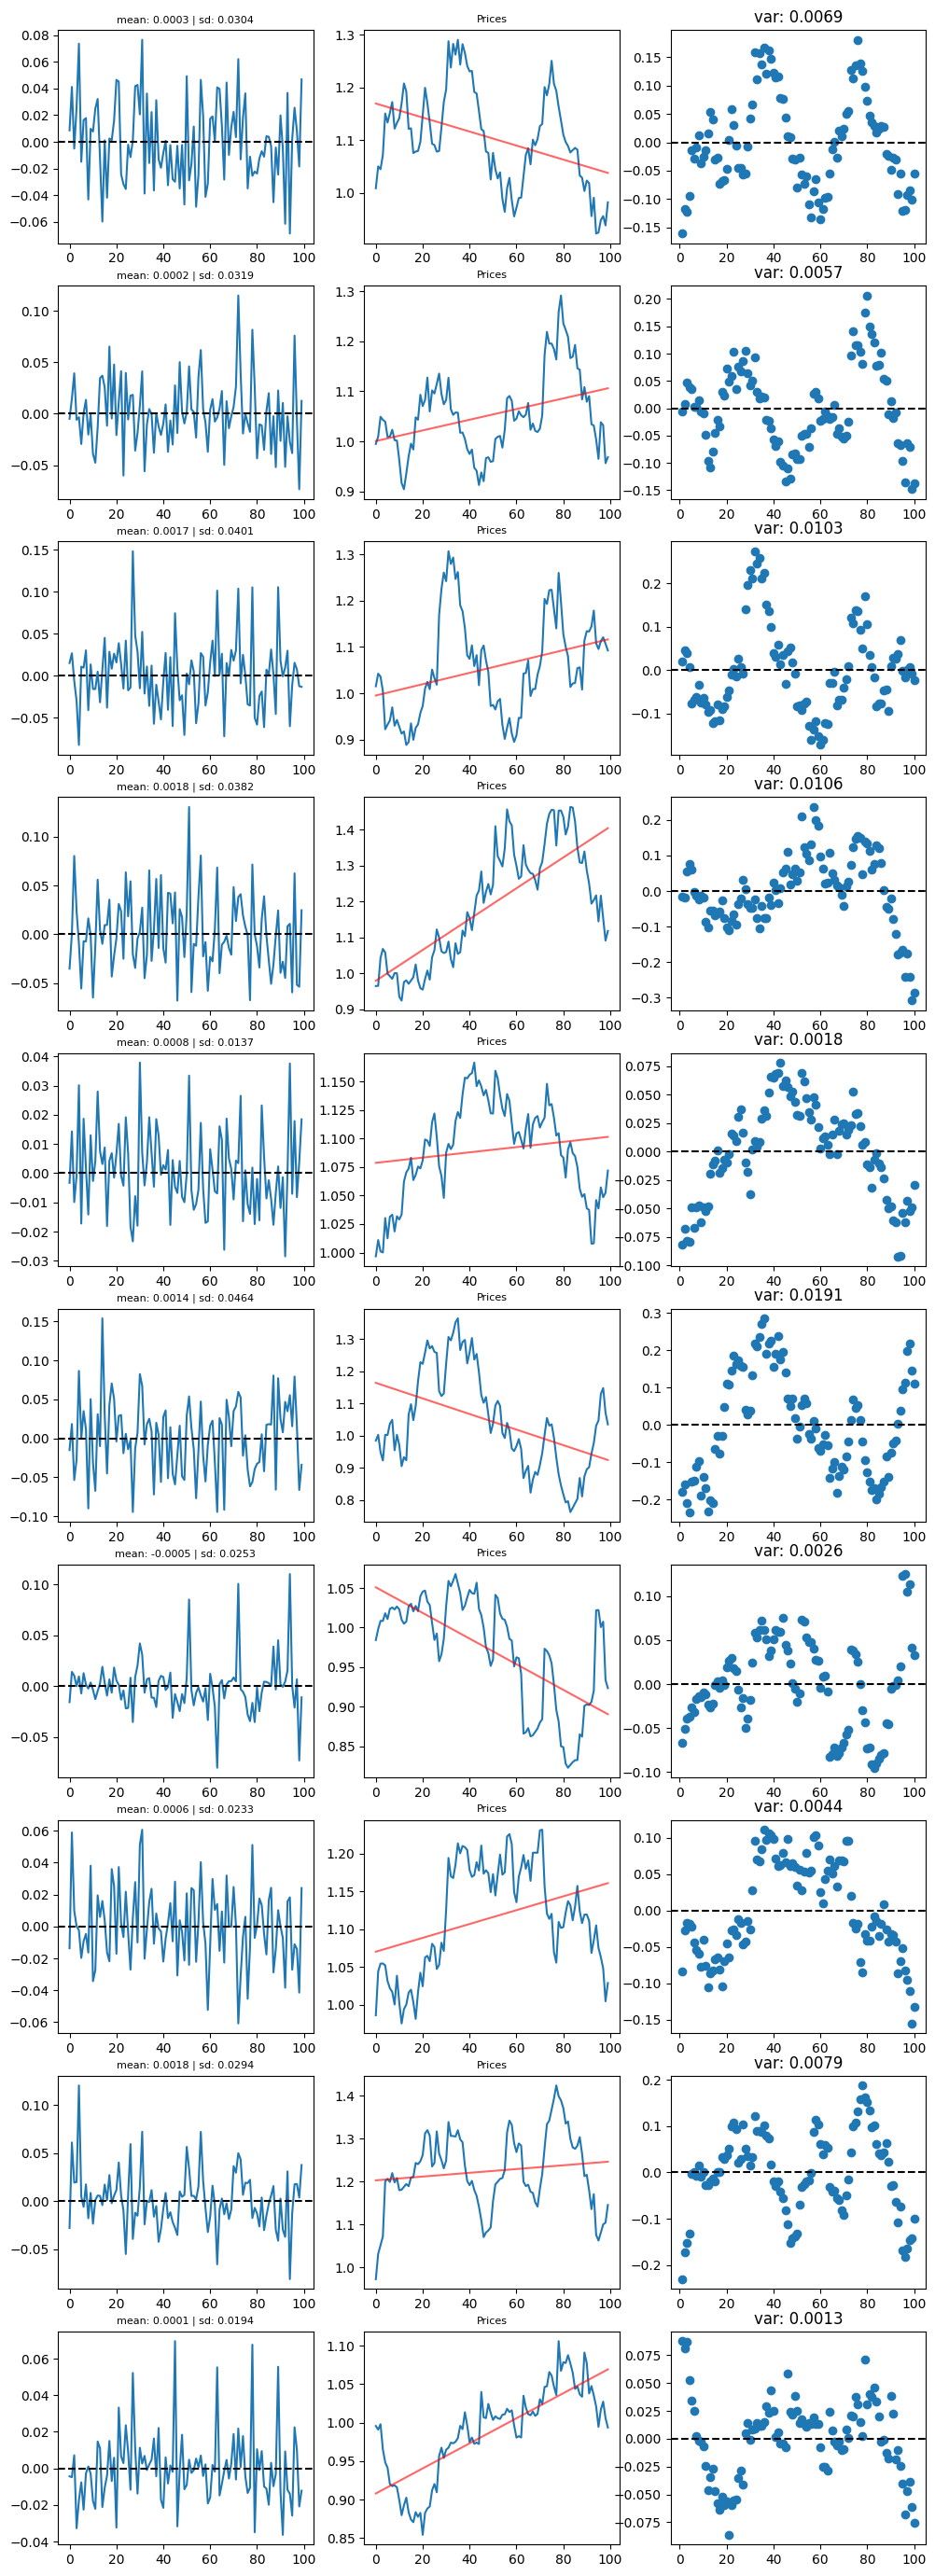

In [45]:
utils.plot_samples_price(syntetic_df, return_series=False)

In [72]:
plain_dataset = data_prep.WindowsDaset(r'data\dataset_price')

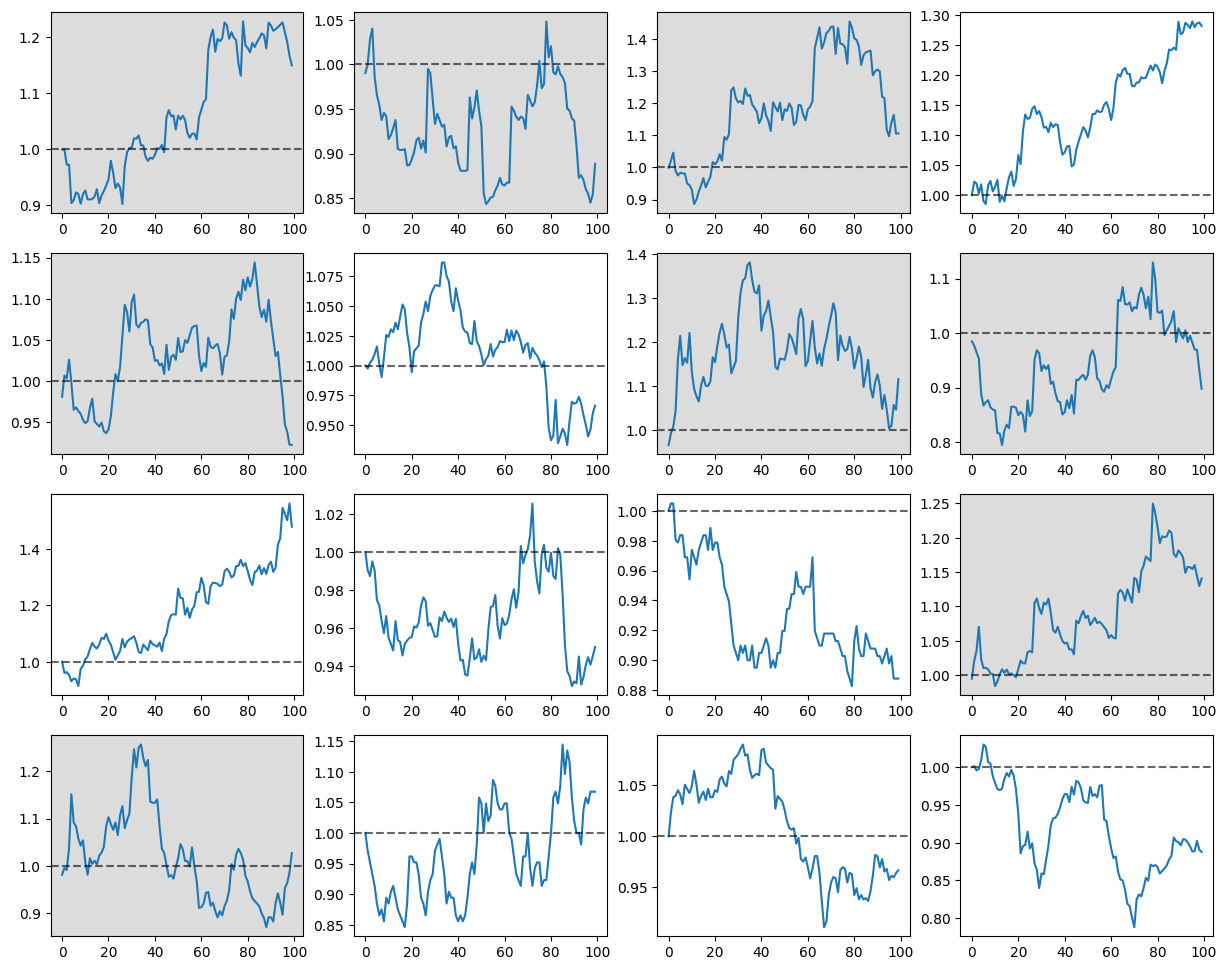

In [103]:
import random

real = [plain_dataset[i].detach().numpy()/plain_dataset[i].detach().numpy()[0] for i in np.random.randint(0, len(dataset),size=8)]
fake = syntetic_df[:8]

generated_price = []

for i in fake:
    single = []
    init = 1
    for p in i:
        init = init + init * p.item()
        single.append(init)

    generated_price.append(single)


series = real + generated_price

label = ['real']*8 +['fake']*8

toplot = list(zip(series, label))

random.shuffle(toplot)

series, labels = zip(*toplot)

fig, axs = plt.subplots(4,4)
fig.set_figheight(12)
fig.set_figwidth(15)

for ax, serie, label in zip(axs.ravel(),series, labels):
    ax.plot(serie)
    ax.axhline(1, color='black', ls='--', alpha = 0.6)
    if label == 'fake':
        ax.set_facecolor('gainsboro')

plt.savefig('results/comparison_README.png')


# Hypotesis test on the mean of the returns generated